In [ ]:
#!unzip /content/MildDemented.zip

In [ ]:
#!unzip /content/ModerateDemented.zip

In [ ]:
#!unzip /content/NonDemented.zip

In [ ]:
#!unzip /content/VeryMildDemented.zip

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import os



2024-11-07 11:49:40.689399: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 11:49:40.740742: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Ensure that TensorFlow uses GPU with CUDA if available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and enabled for TensorFlow")

GPU is available and enabled for TensorFlow


In [4]:


# Dataset Directories
MildDemented_dir = "content/AugmentedAlzheimerDataset/MildDemented"
ModerateDemented_dir = "content/AugmentedAlzheimerDataset/ModerateDemented"
NonDemented_dir = "content/AugmentedAlzheimerDataset/NonDemented"
VeryMildDemented_dir = "content/AugmentedAlzheimerDataset/VeryMildDemented"

# File paths and labels generation
filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

# Combine into a DataFrame
Alzheimer_df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})
print(Alzheimer_df['labels'].value_counts())

# Train-test split
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

# Image Data Generator with Advanced Augmentation
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(244, 244), color_mode='rgb',
                                      class_mode="categorical", batch_size=128, shuffle=True)

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(244, 244), color_mode='rgb',
                                     class_mode="categorical", batch_size=128, shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(244, 244), color_mode='rgb',
                                    class_mode="categorical", batch_size=128, shuffle=False)



Non Demented          9600
Mild Demented         8960
Very Mild Demented    8960
Moderate Demented     6464
Name: labels, dtype: int64
Found 19030 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 4758 validated image filenames belonging to 4 classes.


In [5]:
# Load DenseNet201 with pre-trained ImageNet weights
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze initial DenseNet201 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with advanced optimizer and loss functions
initial_lr = 0.001
lr_schedule = ExponentialDecay(initial_lr, decay_steps=10000, decay_rate=0.96, staircase=True)
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Set callbacks for early stopping, learning rate reduction, and TensorBoard logging
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(train, epochs=25, validation_data=val, callbacks=callbacks)

# Fine-tuning: Unfreeze all layers and retrain with a very low learning rate
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuning
history_fine = model.fit(train, epochs=10, validation_data=val, callbacks=[early_stopping])



2024-11-07 11:49:46.255173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77872 MB memory:  -> device: 0, name: NVIDIA H100 PCIe, pci bus id: 0000:2a:00.0, compute capability: 9.0


Epoch 1/25


2024-11-07 11:49:57.102665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-07 11:49:57.354873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-07 11:49:57.975002: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5aaa00800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 11:49:57.975051: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA H100 PCIe, Compute Capability 9.0
2024-11-07 11:49:57.980470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 11:49:58.139562: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

149/149 [==============================] - 219s 1s/step - loss: 0.9237 - accuracy: 0.6194 - val_loss: 0.8003 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 2/25
149/149 [==============================] - 198s 1s/step - loss: 0.6870 - accuracy: 0.6999 - val_loss: 0.6428 - val_accuracy: 0.7306 - lr: 0.0010
Epoch 3/25
149/149 [==============================] - 191s 1s/step - loss: 0.6238 - accuracy: 0.7297 - val_loss: 0.5614 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 4/25
149/149 [==============================] - 242s 2s/step - loss: 0.5888 - accuracy: 0.7453 - val_loss: 0.5399 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 5/25
149/149 [==============================] - 198s 1s/step - loss: 0.5541 - accuracy: 0.7595 - val_loss: 0.5061 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 6/25
149/149 [==============================] - 232s 2s/step - loss: 0.5259 - accuracy: 0.7739 - val_loss: 0.4817 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 7/25
149/149 [==============================] - 216s 1s/step - loss: 

80/80 [==============================] - 101s 1s/step - loss: 0.2152 - accuracy: 0.9137
Test Accuracy: 91.37%


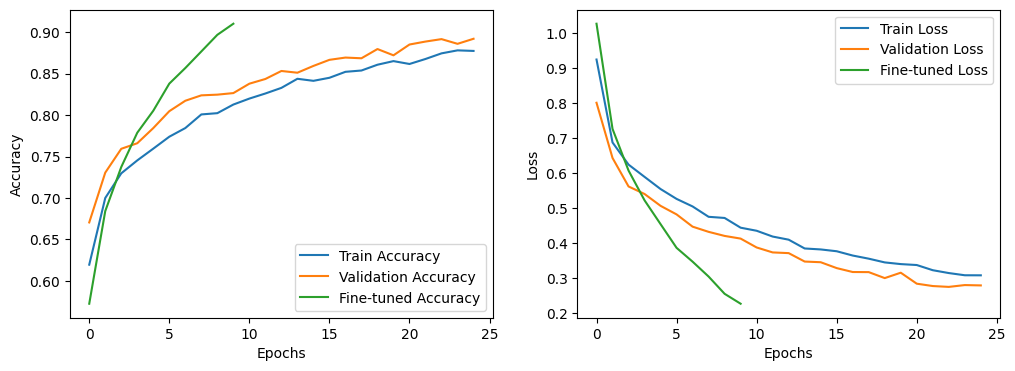

80/80 [==============================] - 107s 1s/step
                    precision    recall  f1-score   support

     Mild Demented       0.93      0.95      0.94      2693
 Moderate Demented       1.00      1.00      1.00      1977
      Non Demented       0.90      0.86      0.88      2811
Very Mild Demented       0.84      0.87      0.86      2715

          accuracy                           0.91     10196
         macro avg       0.92      0.92      0.92     10196
      weighted avg       0.91      0.91      0.91     10196



In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the final model
model.save("novel_alzheimer_model.h5")

# Visualize accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Make predictions
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

# Map predicted labels to actual class names
labels = (train.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred_labels = [labels[k] for k in pred]

# Classification Report
print(classification_report(test.classes, pred, target_names=class_labels))